# Bevezetés a Machine Learning világába a SciKit-Learn segítségével

Az alábbi tutorial a SciKit-Learn dokumentációjából átvett [példaprogram](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html) magyarázattal és néhány kiegészítéssel.

Kis áttekintés/cheat sheet az SKLearn-ben megtalálható módszerekhez (bár ezen túl is van még benne több modell):

In [4]:
from IPython.display import Image
Image(url='https://amueller.github.io/sklearn_tutorial/cheat_sheet.png', width=1200)

A feladatunk arcképek osztályozása egy [felügyelt/supervised tanulási feladatként](http://mialmanach.mit.bme.hu/fogalomtar/felugyelt_tanulas). Az adathalmaz ebben az esetben tehát tartalmazza a jó megoldásokat is (ellenben a nem felügyelt/unsupervised tanulással).

Az alábbi csomagokra lesz szükség, ezek közül a legfontosabbak a `RandomizedSearchCV` és `GridSearchCV` (paraméter-optimalizációban segítenek), `train_test_split` (adathalmaz tréning- és teszthalmazra osztására szolgál), `PCA` (prímkomponens-analízis), `classification_report` és `confusion_matrix` (az eredmények kiértékeléséhez), és végül, de nem utolsósorban a két kipróbált modell, az `SVC` (Support Vector Classifier, azaz támaszvektor-osztályozó) és az `MLPClassifier` (Multi-Layer Perceptron, egy egyszerű neurálisháló-modell).

In [5]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

A `fetch_lfw_people` letölti és beolvassa az SKLearn szervereiről a "Labeled Faces in the Wild (LFW)" adathalmazt, amely emberi arcokról készült képeket és az azokhoz tartozó címkéket (hogy melyik képen ki van) tartalmazza. Összesem 7 ember arcképeivel dolgozunk.

In [6]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]
X.shape

(1288, 1850)

In [7]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Itt bontjuk fel az adatokat tréning- és teszthalmazokra, azon belül pedig külön tároljuk a címkéket.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
X_train.shape

(966, 1850)

### PCA-vizualizáció: 
A PCA értelmezéséhez segítségül szolgálhat az alábbi vizualizáció: https://setosa.io/ev/principal-component-analysis/

A ["könyökszabály"](https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis) szerint kiválasztjuk a prímkomponensek számát:

No handles with labels found to put in legend.


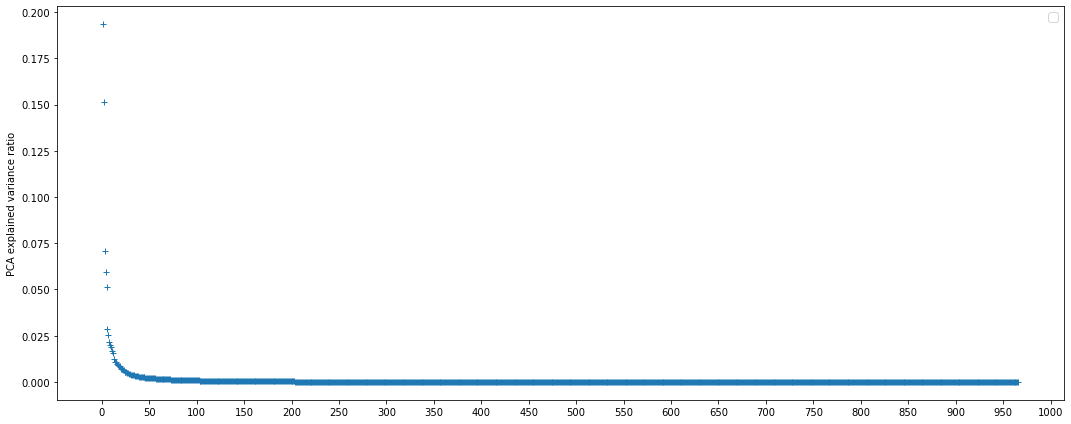

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

pca = PCA(n_components=966)
pca.fit(X_train)

fig, (ax0) = plt.subplots(nrows=1, sharex=True, figsize=(15, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')
ax0.legend(prop=dict(size=12))

tick_spacing = 50
ax0.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.tight_layout()

plt.show()


Fontos, hogy az összes átalakítást a tréninghalmazon kell `.fit`-elni (illeszteni), majd a már felparaméterezett átalakítást a teszthalmazon csak alkalmazni (`.transform`) szabad, hogy elkerüljük az adatszivárgást.

In [10]:
n_components = 25

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 25 eigenfaces from 966 faces
done in 0.093s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s


# Multi-Layer Perceptron

Elsőként próbáljuk ki az MLP-t! Ennek a felépítése az alábbira hasonlít (csak az egyes neuronok és rejtett rétegek száma változhat tetszőlegesen):

In [11]:
Image(url='https://miro.medium.com/max/1200/1*-IPQlOd46dlsutIbUq1Zcw.png', width=1200)

A `RandomizedSearchCV` random módon összepárosítja a `param_grid`-ben megadott paramétereket, betanít egy osztályozót, majd leméri a teljesítményét. Ezután visszaadja ezek közül a legjobban teljesítőt.

In [12]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "hidden_layer_sizes": [[7], [200, 100, 7], [200, 7], [7,7,7,7,7]],
    "max_iter": [50, 500, 1000],
}
clf = RandomizedSearchCV(MLPClassifier(), param_grid, n_jobs=-1)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 38.412s
Best estimator found by grid search:
MLPClassifier(hidden_layer_sizes=[200, 7], max_iter=500)


In [13]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/1024px-Precisionrecall.svg.png", width=500)

Osztályozásnál nem célszerű a `score` (ami általban egy "accuracy"-szerű érték) értékelésre hagyatkozni, inkább az F1 score-t van értelme használni ([here's why](https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2)).

In [14]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.006s
                   precision    recall  f1-score   support

     Ariel Sharon       0.54      0.54      0.54        13
     Colin Powell       0.86      0.85      0.86        60
  Donald Rumsfeld       0.53      0.63      0.58        27
    George W Bush       0.87      0.86      0.87       146
Gerhard Schroeder       0.76      0.64      0.70        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.67      0.78      0.72        36

         accuracy                           0.79       322
        macro avg       0.71      0.70      0.70       322
     weighted avg       0.79      0.79      0.79       322

[[  7   1   2   3   0   0   0]
 [  3  51   3   2   0   0   1]
 [  1   2  17   6   1   0   0]
 [  2   1   9 125   3   2   4]
 [  0   1   0   3  16   0   5]
 [  0   1   0   1   0   9   4]
 [  0   2   1   3   1   1  28]]


# Support Vector Machine
Az SVC (Support Vector Classifier) teljesen máshogy működik, mint az MLP, és általában jobban is teljesít. A Random Forest mellett ez az egyik első modell, amivel próbálkozni szoktam egy naiv baseline-előrejelzés meghatározása után. Bővebben arról, hogy hogy működik, [itt](https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989) találsz leírást!

In [15]:
Image(url="https://miro.medium.com/max/581/1*-4FOSXGyV6CSUOrOPEFc9g.png", width=800)

In [16]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": [1e3, 5e3, 1e4, 5e4, 1e5],
    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 26.785s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)


In [17]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.064s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.72      0.87      0.79        60
  Donald Rumsfeld       0.50      0.56      0.53        27
    George W Bush       0.87      0.82      0.84       146
Gerhard Schroeder       0.58      0.56      0.57        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.70      0.64      0.67        36

         accuracy                           0.75       322
        macro avg       0.69      0.68      0.68       322
     weighted avg       0.76      0.75      0.75       322

[[  9   2   1   1   0   0   0]
 [  2  52   3   2   1   0   0]
 [  3   4  15   4   1   0   0]
 [  2   8   9 119   5   0   3]
 [  0   0   1   5  14   0   5]
 [  0   3   0   1   0   9   2]
 [  0   3   1   5   3   1  23]]


Voilà! El is készültünk az első (két) machine learning modellünkkel! 

Kicsit félrevezető ez a tutorial, ugyanis a munka legnagyobb része valójában legtöbbször az adatok előkészítésével zajlik. Ha az adatok rosszak, tökmindegy, milyen szuper modelled van, az nem fog jól teljesíteni (többszörösen érvényesül a garbage in-garbage out (GIGO) elve). Plusz az adathalmazt modellek számára értelmezhetővé alakítani sokszor nem egyszerű munka.

Végül pedig nézzük meg, milyen előrejelzéseket csinált a modellünk, milyen "sajátarcok" ("eigenfaces", as in sajátvektor/eigenvector) alapján (a PCA-val ezt kapjuk)!

In [18]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

(25, 50, 37)


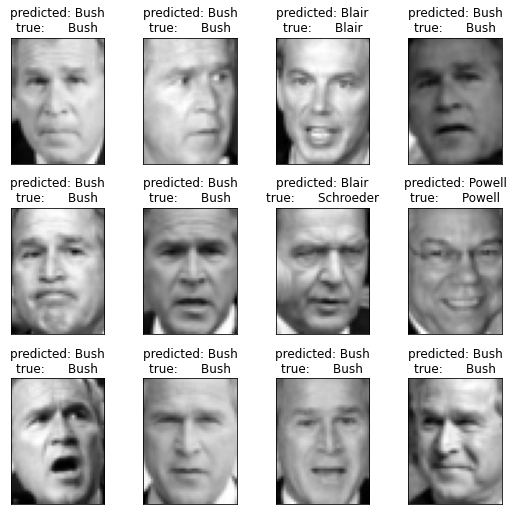

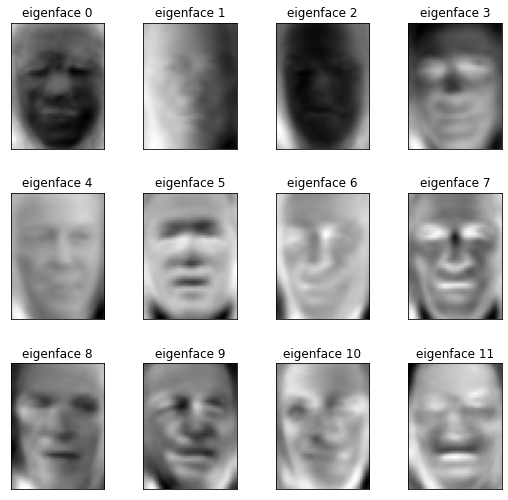

In [19]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces
print(eigenfaces.shape)
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# Köszönöm, hogy velem tartottál! Keress bátran bárhol:
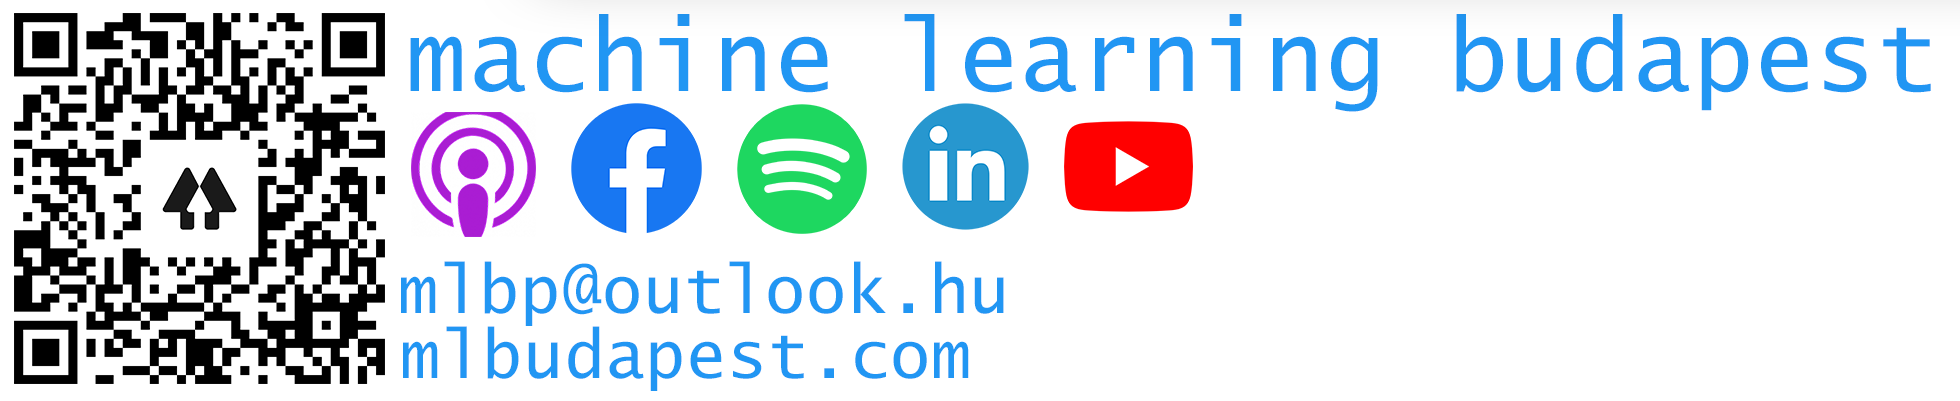